In [82]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy
import plotly_express as px

In [83]:
# path = '/home/richiben/Documents/repos/COVID-19/dati-regioni'
path = r'/richi/repos/COVID-19/dati-regioni/'
files = {}
for fil in ['dpc-covid19-ita-regioni.csv']:#os.listdir(path):
    files[fil.split('.')[0]] = pd.read_csv(os.path.join(path,fil),sep=',')

In [84]:
keyss = list(files.keys())

In [85]:
regoni = files[keyss[0]]

In [86]:
regoni['data'] = pd.to_datetime(regoni['data'])

In [87]:
regoni.set_index(['data'],inplace=True)

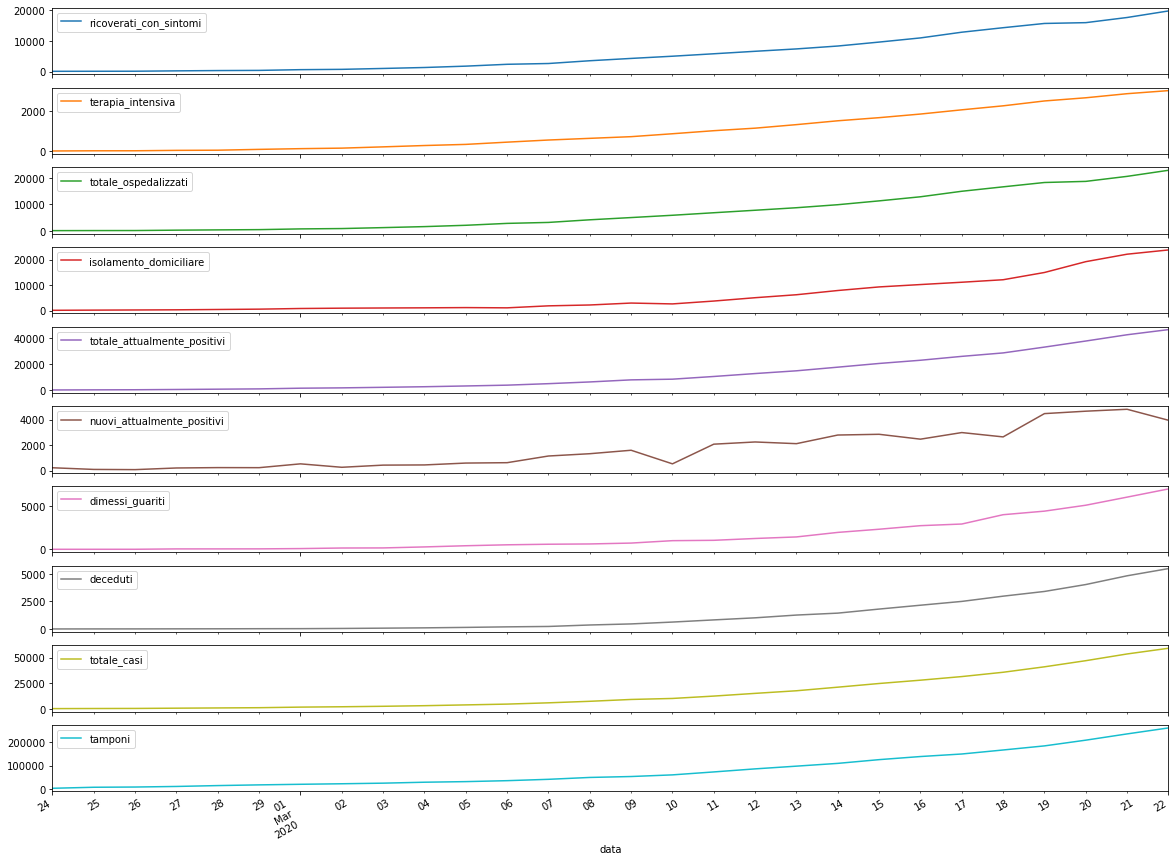

In [88]:
regoni.groupby([pd.Grouper(freq='1d')])[regoni.columns[5:]].sum().plot(subplots=True,figsize=(20,16))
totali = regoni.groupby(pd.Grouper(freq='1d'))[regoni.columns[5:]].sum()

In [89]:
to_plot = (totali[['totale_attualmente_positivi','totale_casi']].diff()/totali[['totale_attualmente_positivi','totale_casi']].shift()).dropna() 
to_plot.reset_index(inplace=True)
to_plot['data'] = to_plot['data'].astype('str')

In [96]:
import plotly.graph_objects as go

years = to_plot['data'].to_list()

fig = go.Figure()
fig.add_trace(go.Bar(x=years, y=to_plot['totale_attualmente_positivi'].to_list(),
                name='attualmente positivi'))
fig.add_trace(go.Bar(x=years, y=to_plot['totale_casi'].to_list(),
                name='casi'
                ))
fig.show()

In [97]:
fig.write_html(r'C:/Users/energyway/Desktop/covid.html')

In [99]:
totali.columns

Index(['ricoverati_con_sintomi', 'terapia_intensiva', 'totale_ospedalizzati',
       'isolamento_domiciliare', 'totale_attualmente_positivi',
       'nuovi_attualmente_positivi', 'dimessi_guariti', 'deceduti',
       'totale_casi', 'tamponi'],
      dtype='object')

,totale_attualmente_positivi,totale_casi,tamponi,deceduti
data,,,,
2020-03-18,2648.0,4207.0,16884.0,475.0
2020-03-19,4480.0,5322.0,17236.0,427.0
2020-03-20,4670.0,5986.0,24109.0,627.0
2020-03-21,4821.0,6557.0,26336.0,793.0
2020-03-22,3957.0,5560.0,25180.0,651.0


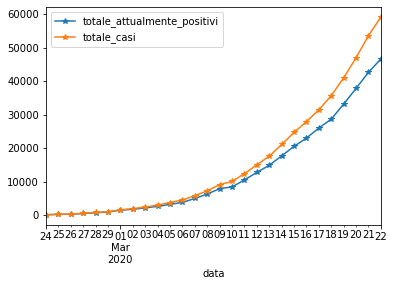

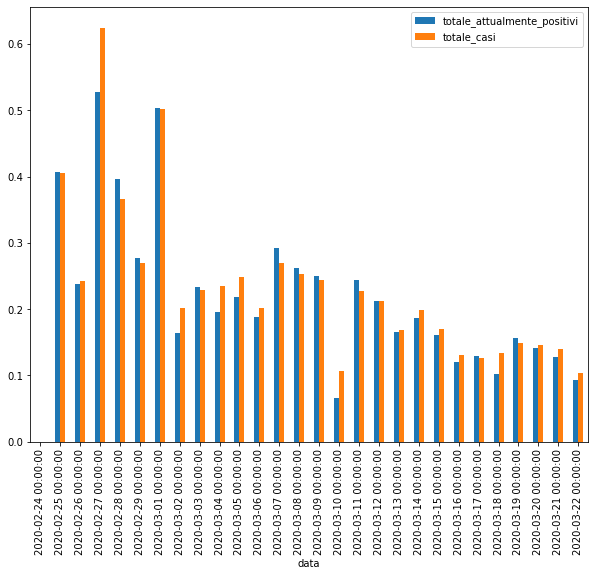

In [101]:
totali[['totale_attualmente_positivi','totale_casi']].plot(marker='*')
(totali[['totale_attualmente_positivi','totale_casi']].diff()/totali[['totale_attualmente_positivi','totale_casi']].shift()).plot(kind='bar',figsize=(10,8))
totali[['totale_attualmente_positivi','totale_casi','tamponi','deceduti']].diff().tail()

In [16]:
def fun(popt,x):
    return popt[0]*np.exp(popt[1]*x)

In [17]:
x = np.arange(len(totali))
y = totali['totale_casi'].values
x_fit = x[:12]
y_fit = y[:12]
print(len(x))
print(len(y))

27
27


In [18]:
popt,pcov = scipy.optimize.curve_fit(lambda t,a,b: fun((a,b),t),  x_fit,  y_fit,p0=(4, 0.1))
print('popt: ', popt)
print('pcov: ',pcov)

popt:  [3.75373516e+02 2.31591483e-01]
pcov:  [[ 1.03987160e+03 -2.83284932e-01]
 [-2.83284932e-01  8.07220840e-05]]


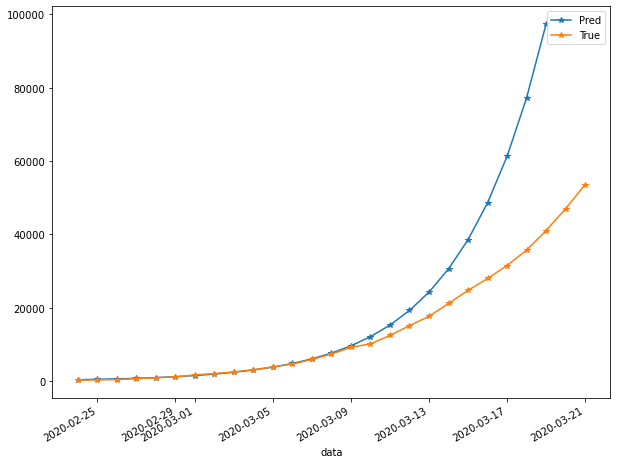

In [22]:
horizon = 25
plt.figure(figsize=(10,8))
datas = pd.date_range(totali.index[0],periods=horizon)
plt.plot(datas,np.array([fun(popt,x_) for x_ in np.arange(horizon)]),marker='*')
totali['totale_casi'].plot(marker='*')
plt.legend(['Pred','True'])

# SIR model

In [23]:
# The SIR model differential equations.

def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

In [24]:
import itertools

In [25]:
gamma_l = np.linspace(0,1,100)
beta_l = np.linspace(1,1,10)

# all_combinations = [list(zip(each_permutation, gamma_l)) for each_permutation in itertools.permutations(beta_l, len(gamma_l))]
all_combination = [x for x in itertools.permutations(gamma_l,2)]

In [29]:
var = 'totale_attualmente_positivi'
# Total population, N.
N = 60e+6
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 229, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 0.2, 1./10 
# A grid of time points (
T = 300
t = np.linspace(0, T, T)


# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
obj0 = 100
for i in tqdm(all_combination):
    beta,gamma = i
    ret = scipy.integrate.odeint(deriv, y0, t, args=(N, beta, gamma))
    S, I, R = ret.T
    obj = np.mean(np.abs((I[:len(totali)]-totali[var].values)/totali[var].values))#+ np.mean(np.abs((R[:len(totali)]-totali['dimessi_guariti'].values)/totali['dimessi_guariti'].values))

    if (obj<obj0)&(beta<0.4):
        obj0 = obj
        better_comb = i
    
print(better_comb)    

100%|█████████████████████████████████████████████████████████████████████████████| 9900/9900 [00:13<00:00, 748.33it/s]

(0.393939393939394, 0.17171717171717174)


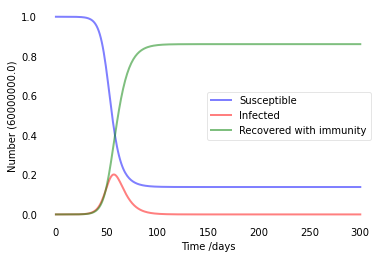

In [30]:
beta,gamma = better_comb
ret = scipy.integrate.odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T
# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111,  axisbelow=True)
ax.plot(t, S/N, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I/N, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/N, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_xlabel('Time /days')
ax.set_ylabel(f'Number ({N})')
# ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

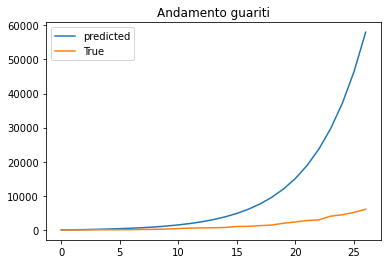

In [31]:
plt.title('Andamento guariti')
plt.plot(R[:len(totali)],label='predicted')
plt.plot(totali['dimessi_guariti'].values,label=True)
plt.legend()

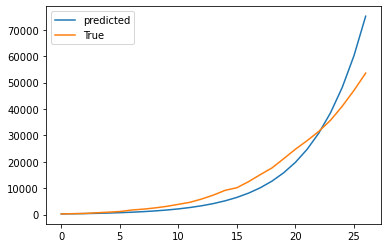

In [32]:
plt.plot(I[:len(totali)],label='predicted')
plt.plot(totali['totale_casi'].values,label=True)
plt.legend()

In [35]:
regoni.columns

Index(['stato', 'codice_regione', 'denominazione_regione', 'lat', 'long',
       'ricoverati_con_sintomi', 'terapia_intensiva', 'totale_ospedalizzati',
       'isolamento_domiciliare', 'totale_attualmente_positivi',
       'nuovi_attualmente_positivi', 'dimessi_guariti', 'deceduti',
       'totale_casi', 'tamponi'],
      dtype='object')

In [58]:
# px.set_mapbox_access_token(open(".mapbox_token").read())
df = regoni.copy()
df.reset_index(inplace=True)
df['data'] = df['data'].astype('str').str[:-8]
px.bar(df,x='denominazione_regione',y='totale_attualmente_positivi',animation_frame='data',range_y=[0,16000])